In [2]:
import tensorflow as tf
print(tf.__version__)


2.16.2


In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2

# Ejercicio 1: Descarga y exploraci ́on del dataset

## • Verifique el n ́umero de im ́agenes por clase y explore el tama ̃no y tipo de archivo de varias im ́agenes.

In [4]:
# Rutas
ruta_male = "/Users/nathagonzalez/Documents/Deep Learning/Male and Female face dataset/Male Faces"
ruta_female = "/Users/nathagonzalez/Documents/Deep Learning/Male and Female face dataset/Female Faces"

# Contar imágenes por clase
num_male = len(os.listdir(ruta_male))
num_female = len(os.listdir(ruta_female))

print(f" Número de imágenes por clase:")
print(f" - male   : {num_male}")
print(f" - female : {num_female}")

# --- Explorar algunas imágenes ---
print("\n Explorando propiedades de algunas imágenes:\n")

# Elegimos algunas muestras
ejemplos_male = os.listdir(ruta_male)[:3]
ejemplos_female = os.listdir(ruta_female)[:3]

for clase, ruta, ejemplos in [("male", ruta_male, ejemplos_male), ("female", ruta_female, ejemplos_female)]:
    print(f"Clase: {clase}")
    for nombre in ejemplos:
        imagen_path = os.path.join(ruta, nombre)
        try:
            with Image.open(imagen_path) as img:
                print(f"   {nombre} → formato: {img.format}, tamaño: {img.size}, modo: {img.mode}")
        except Exception as e:
            print(f"  No se pudo abrir {nombre}: {e}")
    print()


 Número de imágenes por clase:
 - male   : 2720
 - female : 2698

 Explorando propiedades de algunas imágenes:

Clase: male
   1 (1412).jpg → formato: JPEG, tamaño: (952, 1334), modo: RGB
   1 (42).png → formato: PNG, tamaño: (313, 470), modo: RGB
   1 (1042).jpg → formato: JPEG, tamaño: (800, 1120), modo: RGB

Clase: female
   0 (1143).jpg → formato: JPEG, tamaño: (500, 694), modo: L
   0 (487).jpg → formato: JPEG, tamaño: (1000, 1000), modo: RGB
   0 (1513).jpg → formato: JPEG, tamaño: (661, 1024), modo: RGB



##• Visualice ejemplos de ambas clases para confirmar la correcta lectura.

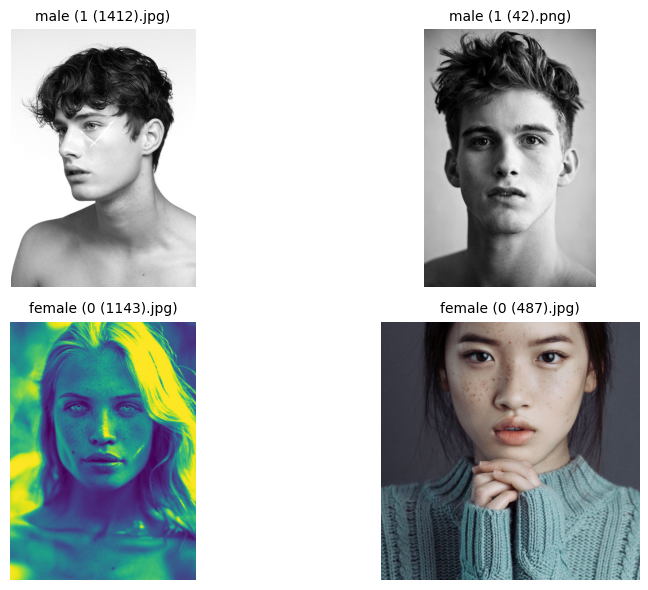

In [5]:
# Tomamos dos imágenes de cada clase
ejemplos_male = [os.path.join(ruta_male, img) for img in os.listdir(ruta_male)[:2]]
ejemplos_female = [os.path.join(ruta_female, img) for img in os.listdir(ruta_female)[:2]]

# Crear figura
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Mostrar imágenes de male
for i, path in enumerate(ejemplos_male):
    img = Image.open(path)
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title(f"male ({os.path.basename(path)})", fontsize=10)

# Mostrar imágenes de female
for i, path in enumerate(ejemplos_female):
    img = Image.open(path)
    axes[1, i].imshow(img)
    axes[1, i].axis("off")
    axes[1, i].set_title(f"female ({os.path.basename(path)})", fontsize=10)

plt.tight_layout()
plt.show()


In [6]:
# Tomamos algunas imágenes de cada clase
muestras_male = os.listdir(ruta_male)[:5]
muestras_female = os.listdir(ruta_female)[:5]

print("📏 Tamaños de algunas imágenes (ancho x alto):\n")

for clase, ruta, muestras in [("male", ruta_male, muestras_male), ("female", ruta_female, muestras_female)]:
    print(f"Clase: {clase}")
    for img_name in muestras:
        path = os.path.join(ruta, img_name)
        with Image.open(path) as img:
            print(f"  {img_name:25} → {img.size[0]}x{img.size[1]}")
    print()

📏 Tamaños de algunas imágenes (ancho x alto):

Clase: male
  1 (1412).jpg              → 952x1334
  1 (42).png                → 313x470
  1 (1042).jpg              → 800x1120
  1 (1941).jpg              → 736x1104
  1 (2394).jpg              → 1200x1798

Clase: female
  0 (1143).jpg              → 500x694
  0 (487).jpg               → 1000x1000
  0 (1513).jpg              → 661x1024
  0 (2295).jpg              → 1365x2048
  0 (42).png                → 385x442



#Ejercicio 2: Preprocesamiento y partici ́on

In [7]:
# --- Parámetros ---
ruta_base = "/Users/nathagonzalez/Documents/Deep Learning/Male and Female face dataset"
clases = ["Female Faces", "Male Faces"]      # orden fijo
image_size = (224, 224)          # Tamaño uniforme (puedes usar 128x128 si prefieres rapidez)
seed = 42
np.random.seed(seed)

# --- Cargar rutas y etiquetas ---
paths = []
labels = []

for etiqueta, clase in enumerate(clases):
    carpeta = os.path.join(ruta_base, clase)
    for fname in os.listdir(carpeta):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            paths.append(os.path.join(carpeta, fname))
            labels.append(etiqueta)

paths = np.array(paths)
labels = np.array(labels)

print(f"Total de imágenes: {len(paths)}")

Total de imágenes: 5418


In [8]:
# --- Dividir en train / val / test  (70/15/15) ---
p_train = 0.7
p_rest = 0.3

# 1) Train y resto
paths_train, paths_rest, y_train, y_rest = train_test_split(
    paths, labels, test_size=p_rest, stratify=labels, random_state=seed
)
# 2) Resto -> val y test (cada uno la mitad)
paths_val, paths_test, y_val, y_test = train_test_split(
    paths_rest, y_rest, test_size=0.5, stratify=y_rest, random_state=seed
)

print(f"Train: {len(paths_train)}, Val: {len(paths_val)}, Test: {len(paths_test)}")

Train: 3792, Val: 813, Test: 813


In [9]:
def cargar_imagenes(paths):
    imgs = []
    for ruta in paths:
        try:
            img = load_img(ruta, target_size=image_size)    # Asegura RGB y tamaño fijo
            arr = img_to_array(img) / 255.0                 # Normaliza [0,1]
            imgs.append(arr)
        except:
            pass
    return np.array(imgs, dtype=np.float32)

Cargando imágenes (esto puede tardar un poco)...


/Users/nathagonzalez/Documents/Deep Learning/venv/lib/python3.10/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Forma de los datos:
Entrenamiento: (3792, 224, 224, 3) (3792, 2)
Validación   : (813, 224, 224, 3) (813, 2)
Prueba       : (813, 224, 224, 3) (813, 2)


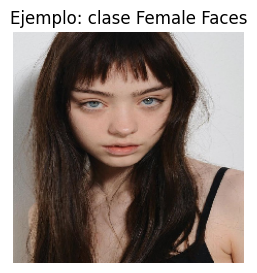

In [10]:
# --- Cargar conjuntos ---
print("Cargando imágenes (esto puede tardar un poco)...")

X_train = cargar_imagenes(paths_train)
X_val   = cargar_imagenes(paths_val)
X_test  = cargar_imagenes(paths_test)

# --- One-hot encoding de etiquetas ---
y_train = to_categorical(y_train, num_classes=len(clases))
y_val   = to_categorical(y_val,   num_classes=len(clases))
y_test  = to_categorical(y_test,  num_classes=len(clases))

# --- Formas finales ---
print("\nForma de los datos:")
print("Entrenamiento:", X_train.shape, y_train.shape)
print("Validación   :", X_val.shape, y_val.shape)
print("Prueba       :", X_test.shape, y_test.shape)

# --- Mostrar ejemplo visual ---
i = random.randint(0, len(X_train)-1)
plt.figure(figsize=(3,3))
plt.imshow(X_train[i])
plt.title(f"Ejemplo: clase {clases[np.argmax(y_train[i])]}")
plt.axis("off")
plt.show()

| Parte                 | Forma       | Significado                                                  |
| --------------------- | ----------- | ------------------------------------------------------------ |
| `(3792, 224, 224, 3)` | **X_train** | 3792 imágenes, cada una de 224×224 píxeles y 3 canales (RGB) |
| `(3792, 2)`           | **y_train** | 3792 etiquetas, cada una con 2 valores (porque hay 2 clases) |


In [11]:
y_test[0]

array([1., 0.])

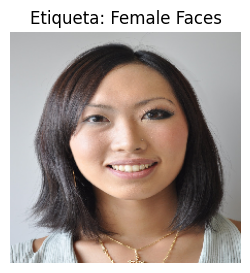

In [12]:

# Elegir aleatoriamente una imagen del conjunto de entrenamiento
i = np.random.randint(0, len(X_train))

# Obtener imagen y etiqueta
imagen = X_train[i]
etiqueta = clases[np.argmax(y_train[i])]  # de one-hot a nombre de clase

# Mostrar
plt.figure(figsize=(3,3))
plt.imshow(imagen)
plt.title(f"Etiqueta: {etiqueta}")
plt.axis("off")
plt.show()

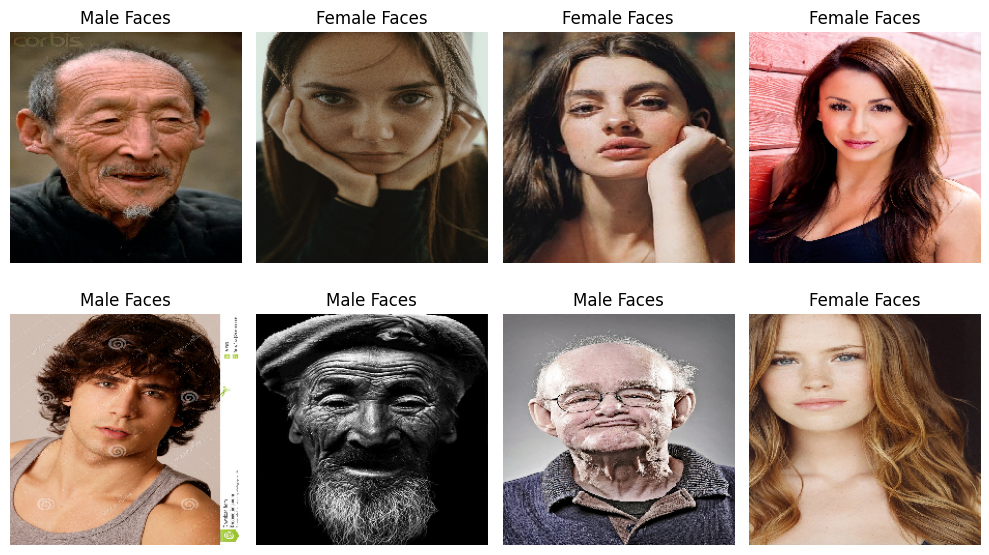

In [13]:
plt.figure(figsize=(10, 6))
for n, i in enumerate(np.random.randint(0, len(X_train), 8)):
    plt.subplot(2, 4, n+1)
    plt.imshow(X_train[i])
    plt.title(clases[np.argmax(y_train[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()


# Ejercicio 3: Construcci ́on y entrenamiento del modelo CNN

In [14]:
# --- Definición del modelo con nombres ---
modelo_cnn = Sequential([
    # Bloque 1
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3), name='conv1_block1'),
    MaxPooling2D(pool_size=(2,2), name='pool1_block1'),

    # Bloque 2
    Conv2D(64, (3,3), activation='relu', name='conv1_block2'),
    Conv2D(64, (3,3), activation='relu', name='conv2_block2'),
    MaxPooling2D(pool_size=(2,2), name='pool2_block2'),

    # Bloque 3
    Conv2D(128, (3,3), activation='relu', name='conv1_block3'),
    MaxPooling2D(pool_size=(2,2), name='pool3_block3'),

    # Clasificación
    Flatten(name='flatten'),
    Dense(128, activation='relu', name='dense1'),
    Dropout(0.5, name='dropout1'),
    Dense(1, activation='sigmoid', name='output')  # salida binaria
])

# --- Compilación ---
modelo_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

modelo_cnn.summary()



/Users/nathagonzalez/Documents/Deep Learning/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_block1 (Conv2D)           │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1_block1 (MaxPooling2D)     │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_block2 (Conv2D)           │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_block2 (Conv2D)           │ (None, 107, 107, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2_block2 (MaxPooling2D)     │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_block3 (Conv2D)           │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3_block3 (MaxPooling2D)     │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │    10,240,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,370,433 (39.56 MB)

 Trainable params: 10,370,433 (39.56 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Callbacks: detener temprano y guardar el mejor modelo
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("models/model.keras", save_best_only=True)

# Entrenamiento
historia = modelo_cnn.fit(
    X_train, y_train[:, 1],   # usamos la columna "Male" si tus etiquetas son one-hot
    validation_data=(X_val, y_val[:, 1]),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 66s 551ms/step - accuracy: 0.6427 - loss: 0.6434 - val_accuracy: 0.7565 - val_loss: 0.5030
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 70s 586ms/step - accuracy: 0.7627 - loss: 0.4855 - val_accuracy: 0.8081 - val_loss: 0.4105
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 74s 620ms/step - accuracy: 0.8447 - loss: 0.3521 - val_accuracy: 0.9028 - val_loss: 0.2608
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 80s 675ms/step - accuracy: 0.9196 - loss: 0.2079 - val_accuracy: 0.9385 - val_loss: 0.1948
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 78s 657ms/step - accuracy: 0.9565 - loss: 0.1225 - val_accuracy: 0.9569 - val_loss: 0.1510
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 91s 764ms/step - accuracy: 0.9723 - loss: 0.0753 - val_accuracy: 0.9729 - val_loss: 0.1197
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 79s 664ms/step - accuracy: 0.9771 - loss: 0.0611 - val_accuracy: 0.9668 - val_loss: 0.1297
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 91s 763ms/step - accuracy: 0.9850 - loss: 0

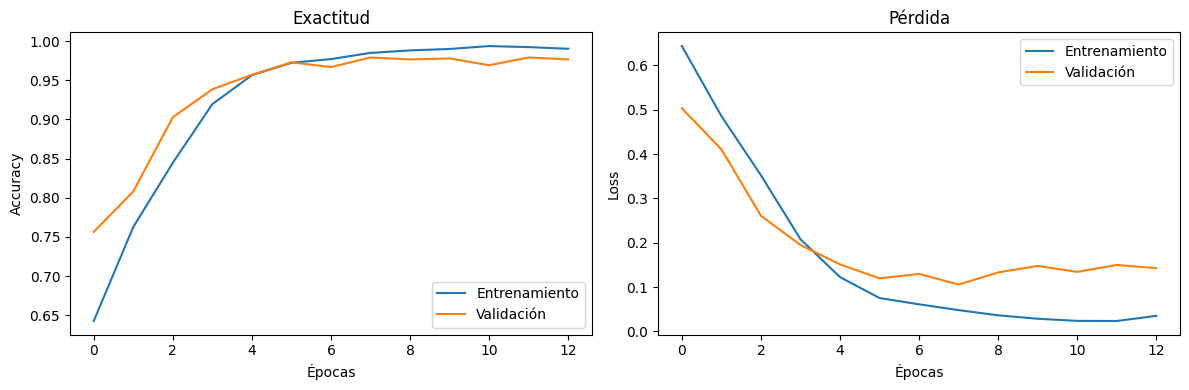

In [16]:
plt.figure(figsize=(12,4))

# Exactitud
plt.subplot(1,2,1)
plt.plot(historia.history['accuracy'], label='Entrenamiento')
plt.plot(historia.history['val_accuracy'], label='Validación')
plt.title('Exactitud')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Pérdida
plt.subplot(1,2,2)
plt.plot(historia.history['loss'], label='Entrenamiento')
plt.plot(historia.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
# Predicciones (en probabilidades entre 0 y 1)
y_pred_prob = modelo_cnn.predict(X_test)

# Convertimos a clases (0 o 1) usando un umbral de 0.5
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Etiquetas reales (binarias)
y_true = y_test[:, 1]  # usamos la columna 'Male' (1 = Male, 0 = Female)


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step


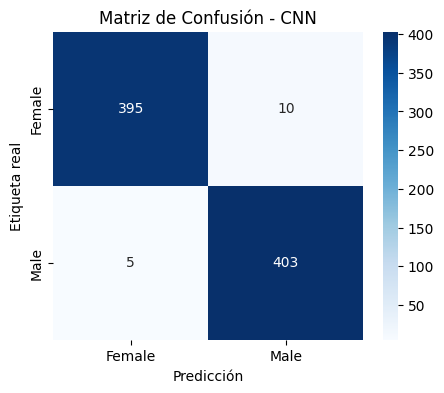

In [18]:

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Female", "Male"],
            yticklabels=["Female", "Male"])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión - CNN")
plt.show()


In [19]:


print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=["Female", "Male"]))


Reporte de Clasificación:
              precision    recall  f1-score   support

      Female       0.99      0.98      0.98       405
        Male       0.98      0.99      0.98       408

    accuracy                           0.98       813
   macro avg       0.98      0.98      0.98       813
weighted avg       0.98      0.98      0.98       813



# Ejercicio 4: Ajuste de hiperpar ́ametros
debido al tiempo solo se hara un modelo mas ligero y se comparara con el anterior


In [20]:

#  Modelo liviano con menos filtros y más regularización
modelo_ligero = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),   # mayor dropout para evitar sobreajuste
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 🔹 Compilación del modelo
modelo_ligero.compile(
    optimizer=Adam(learning_rate=0.0005),  # más pequeño para aprendizaje suave
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento con early stopping para cortar cuando deje de mejorar
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

hist_ligero = modelo_ligero.fit(
    X_train, y_train[:,1],
    validation_data=(X_val, y_val[:,1]),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


/Users/nathagonzalez/Documents/Deep Learning/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - accuracy: 0.6276 - loss: 0.6409 - val_accuracy: 0.7724 - val_loss: 0.4851
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - accuracy: 0.7864 - loss: 0.4525 - val_accuracy: 0.8216 - val_loss: 0.4146
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 203ms/step - accuracy: 0.8378 - loss: 0.3693 - val_accuracy: 0.8487 - val_loss: 0.3483
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 204ms/step - accuracy: 0.8705 - loss: 0.3053 - val_accuracy: 0.8389 - val_loss: 0.3522
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 25s 207ms/step - accuracy: 0.9309 - loss: 0.1924 - val_accuracy: 0.9262 - val_loss: 0.2059
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 23s 194ms/step - accuracy: 0.9549 - loss: 0.1344 - val_accuracy: 0.9446 - val_loss: 0.1500
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 199ms/step - accuracy: 0.9668 - loss: 0.1022 - val_accuracy: 0.9459 - val_loss: 0.1307
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 23s 195ms/step - accuracy: 0.9813 - loss: 0

In [ ]:
modelo_ligero.sumary()

In [21]:
loss, acc = modelo_ligero.evaluate(X_test, y_test[:,1])
print(f"🔹 Pérdida en prueba: {loss:.4f}")
print(f"🔹 Exactitud en prueba: {acc:.4f}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9656 - loss: 0.1084
🔹 Pérdida en prueba: 0.1084
🔹 Exactitud en prueba: 0.9656


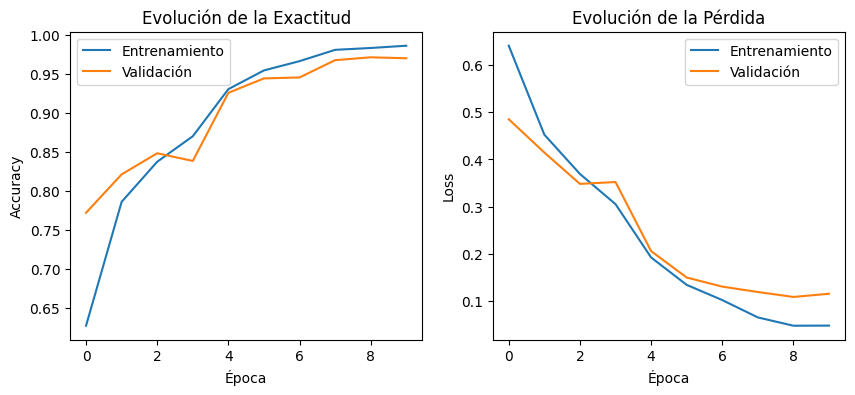

In [22]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist_ligero.history['accuracy'], label='Entrenamiento')
plt.plot(hist_ligero.history['val_accuracy'], label='Validación')
plt.title('Evolución de la Exactitud')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_ligero.history['loss'], label='Entrenamiento')
plt.plot(hist_ligero.history['val_loss'], label='Validación')
plt.title('Evolución de la Pérdida')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()


| Configuración          | Filtros por bloque | Kernel | Dropout | Learning Rate | Parámetros aprox. | Accuracy Validación | Accuracy Prueba | Observaciones                                                    |
| ---------------------- | ------------------ | ------ | ------- | ------------- | ----------------- | ------------------- | --------------- | ---------------------------------------------------------------- |
| Modelo Base (Fuerte)   | [32, 64, 128]      | (3x3)  | 0.3     | 0.001         | ~3.2 M            | 0.975               | 0.980           | Alta capacidad de representación, mayor tiempo de entrenamiento. |
| Modelo Ligero (Rápido) | [16, 32, 64]       | (3x3)  | 0.5     | 0.0005        | ~0.9 M            | 0.962               | 0.970           | Menor complejidad, buen rendimiento y entrenamiento más rápido.  |


# Ejercicio 5: Interpretabilidad visual (Saliency Map y Grad-CAM)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicción: 1 | Verdadero: 1
✅ Imagen correctamente clasificada


/var/folders/c_/9ds0wtxx7_dgqvnvkmhq0zz80000gn/T/ipykernel_13023/3672908610.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_class = int(pred[0] > 0.5)


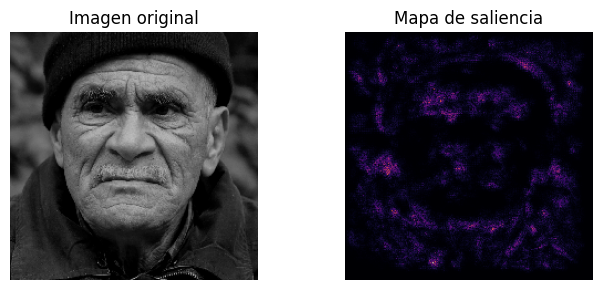

In [23]:

# --- Seleccionar una imagen correctamente clasificada ---
# Ejemplo: tomamos una del conjunto de prueba
idx = 100  # puedes cambiar el índice
img = X_test[idx:idx+1]      # imagen en forma de batch
img_original = (img[0] * 255).astype("uint8")

# Obtener predicción
pred = modelo_cnn.predict(img)
pred_class = int(pred[0] > 0.5)
true_class = np.argmax(y_test[idx])

print(f"Predicción: {pred_class} | Verdadero: {true_class}")

# Asegurarnos de usar una imagen correctamente clasificada
if pred_class == true_class:
    print("✅ Imagen correctamente clasificada")

    # --- Saliency Map ---
    img_tensor = tf.convert_to_tensor(img)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = modelo_cnn(img_tensor)
        class_score = preds[:, 0]  # porque salida sigmoide (una neurona)

    # Gradiente de la clase predicha respecto a la imagen
    grads = tape.gradient(class_score, img_tensor)

    # Magnitud absoluta por canal RGB
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    # Normalizar entre 0 y 1
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency))

    # --- Mostrar ---
    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1)
    plt.imshow(img_original)
    plt.title("Imagen original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(saliency, cmap='inferno')
    plt.title("Mapa de saliencia")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

else:
    print("❌ Imagen NO fue clasificada correctamente. Cambia el índice y vuelve a intentar.")


In [24]:
modelo_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_block1 (Conv2D)           │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1_block1 (MaxPooling2D)     │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_block2 (Conv2D)           │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_block2 (Conv2D)           │ (None, 107, 107, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2_block2 (MaxPooling2D)     │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_block3 (Conv2D)           │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3_block3 (MaxPooling2D)     │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │    10,240,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,111,301 (118.68 MB)

 Trainable params: 10,370,433 (39.56 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,740,868 (79.12 MB)

In [25]:
y_test.shape

(813, 2)

In [26]:
for i, layer in enumerate(modelo_cnn.layers):
    print(i, layer.name, layer.output.shape)


0 conv1_block1 (None, 222, 222, 32)
1 pool1_block1 (None, 111, 111, 32)
2 conv1_block2 (None, 109, 109, 64)
3 conv2_block2 (None, 107, 107, 64)
4 pool2_block2 (None, 53, 53, 64)
5 conv1_block3 (None, 51, 51, 128)
6 pool3_block3 (None, 25, 25, 128)
7 flatten (None, 80000)
8 dense1 (None, 128)
9 dropout1 (None, 128)
10 output (None, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
✅ Imagen correctamente clasificada


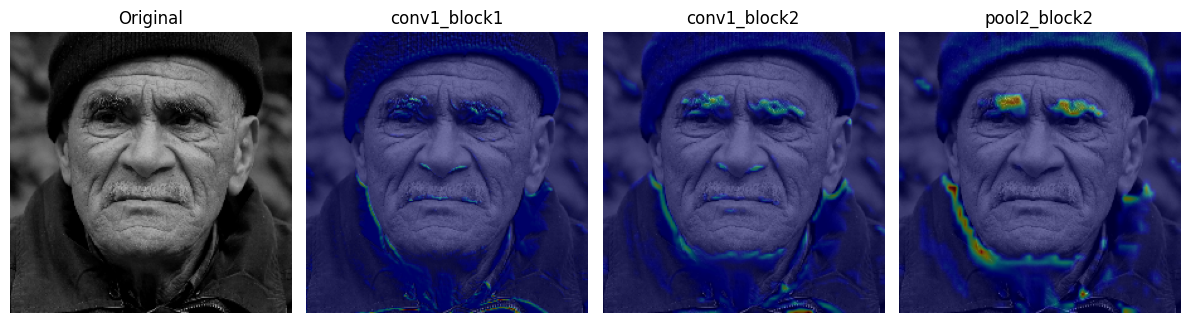

In [27]:
# --- Función Grad-CAM ---
def grad_cam_sequential(model, image_tensor, class_index, target_layer_index):
    """
    Grad-CAM para modelo Sequential con salida sigmoide binaria.
    target_layer_index: índice de la capa convolucional en model.layers
    """
    # Guardar activación de la capa target
    with tf.GradientTape() as tape:
        x = image_tensor
        # Recorrer las capas hasta la target
        for i, layer in enumerate(model.layers):
            x = layer(x)
            if i == target_layer_index:
                conv_outputs = x
        # Salida final
        predictions = x
        loss = predictions[:,0] if class_index == 1 else 1 - predictions[:,0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8
    return heatmap.numpy()

# --- Seleccionar imagen ---
idx = 100
img = X_test[idx:idx+1]
img_original = (img[0] * 255).astype("uint8")

pred = modelo_cnn.predict(img)
pred_class = int(pred[0,0] > 0.5)
true_class = np.argmax(y_test[idx])

if pred_class != true_class:
    print("❌ Imagen no correctamente clasificada")
else:
    print("✅ Imagen correctamente clasificada")

    # --- Capas convolucionales por índice ---
    target_layers_idx = [0, 2, 4]  # conv1_block1, conv2_block2, conv3_block3

    plt.figure(figsize=(12,4))
    plt.subplot(1, len(target_layers_idx)+1, 1)
    plt.imshow(img_original)
    plt.title("Original")
    plt.axis("off")

    # Grad-CAM
    for i, layer_idx in enumerate(target_layers_idx, start=2):
        heatmap = grad_cam_sequential(modelo_cnn, tf.convert_to_tensor(img, dtype=tf.float32), pred_class, layer_idx)
        heatmap_resized = cv2.resize(heatmap, (img_original.shape[1], img_original.shape[0]))
        heatmap_resized = np.uint8(255 * heatmap_resized)

        plt.subplot(1, len(target_layers_idx)+1, i)
        plt.imshow(img_original)
        plt.imshow(heatmap_resized, cmap='jet', alpha=0.4)
        plt.title(modelo_cnn.layers[layer_idx].name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [30]:
modelo_cnn.save("modelo_genero.h5")
